In [1]:
pip install librosa matplotlib numpy tkinter


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


In [2]:
pip install tkinter


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox
import librosa
import numpy as np
import matplotlib.pyplot as plt


Step 1: Detecting Unnatural Gaps
Detected potential unnatural gaps (silences):
Silence from 0.00s to 141.41s

Step 2: Detecting Background Noise Mismatches
Detected potential noise mismatches (background noise change):
Sudden noise change between segment 3 and 4
Sudden noise change between segment 23 and 24
Sudden noise change between segment 24 and 25
Sudden noise change between segment 25 and 26
Sudden noise change between segment 96 and 97
Sudden noise change between segment 100 and 101
Sudden noise change between segment 113 and 114
Sudden noise change between segment 114 and 115
Sudden noise change between segment 117 and 118

Step 3: Detecting Spliced Sections


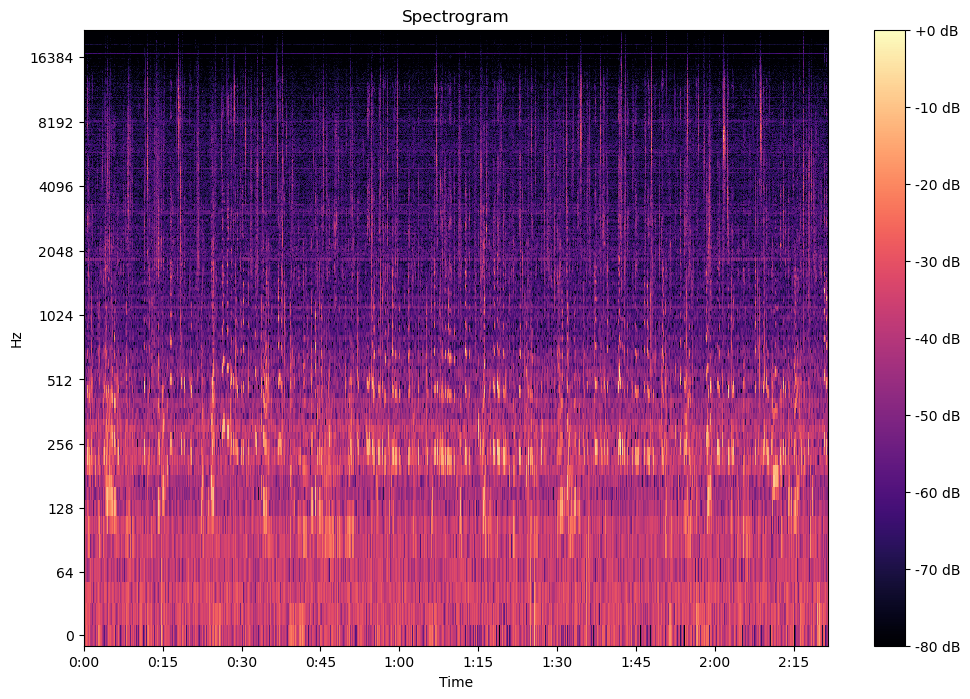

Detected potential spliced sections (frequency spectrum changes):
Splice at approximately 0.02s
Splice at approximately 0.03s
Splice at approximately 0.07s
Splice at approximately 0.57s
Splice at approximately 0.62s
Splice at approximately 0.81s
Splice at approximately 0.86s
Splice at approximately 0.87s
Splice at approximately 0.89s
Splice at approximately 0.91s
Splice at approximately 0.93s
Splice at approximately 0.94s
Splice at approximately 1.00s
Splice at approximately 1.01s
Splice at approximately 1.34s
Splice at approximately 1.37s
Splice at approximately 1.38s
Splice at approximately 1.44s
Splice at approximately 1.45s
Splice at approximately 2.59s
Splice at approximately 2.61s
Splice at approximately 4.12s
Splice at approximately 4.13s
Splice at approximately 4.77s
Splice at approximately 4.78s
Splice at approximately 5.21s
Splice at approximately 5.22s
Splice at approximately 7.84s
Splice at approximately 8.47s
Splice at approximately 8.54s
Splice at approximately 10.41s
Spl

In [5]:
def analyze_audio(file_path):
    # Call the forensic functions after file is selected
    print("\nStep 1: Detecting Unnatural Gaps")
    silences = detect_silences(file_path)

    print("\nStep 2: Detecting Background Noise Mismatches")
    noise_mismatches = detect_noise_mismatch(file_path)

    print("\nStep 3: Detecting Spliced Sections")
    spliced_sections = detect_splicing(file_path)

    messagebox.showinfo("Analysis Complete", "Audio Forensic Analysis Complete!")

# Function to detect silences
def detect_silences(file_path, silence_threshold=-40, min_silence_duration=0.5):
    y, sr = librosa.load(file_path, sr=None)
    silent_intervals = librosa.effects.split(y, top_db=-silence_threshold)
    silence_durations = [(start / sr, end / sr) for start, end in silent_intervals if (end - start) / sr >= min_silence_duration]

    if silence_durations:
        print("Detected potential unnatural gaps (silences):")
        for start, end in silence_durations:
            print(f"Silence from {start:.2f}s to {end:.2f}s")
    else:
        print("No unnatural silences detected.")
    return silence_durations

# Function to detect noise mismatch
def detect_noise_mismatch(file_path, segment_duration=1.0):
    y, sr = librosa.load(file_path, sr=None)
    total_duration = len(y) / sr
    num_segments = int(np.floor(total_duration / segment_duration))

    noise_levels = []
    for i in range(num_segments):
        start = int(i * segment_duration * sr)
        end = int((i + 1) * segment_duration * sr)
        segment = y[start:end]
        rms_energy = np.mean(librosa.feature.rms(y=segment))
        noise_levels.append(rms_energy)

    noise_diff = np.diff(noise_levels)
    large_noise_jumps = np.where(np.abs(noise_diff) > np.mean(noise_diff) + 2 * np.std(noise_diff))[0]

    if large_noise_jumps.size > 0:
        print("Detected potential noise mismatches (background noise change):")
        for idx in large_noise_jumps:
            print(f"Sudden noise change between segment {idx} and {idx+1}")
    else:
        print("No significant noise mismatches detected.")
    return large_noise_jumps

# Function to detect spliced sections
def detect_splicing(file_path):
    y, sr = librosa.load(file_path, sr=None)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    plt.figure(figsize=(12, 8))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    energy_diff = np.diff(np.mean(D, axis=0))
    spliced_sections = np.where(np.abs(energy_diff) > np.mean(energy_diff) + 2 * np.std(energy_diff))[0]

    if spliced_sections.size > 0:
        print("Detected potential spliced sections (frequency spectrum changes):")
        for idx in spliced_sections:
            time_splice = idx * (len(y) / sr / D.shape[1])
            print(f"Splice at approximately {time_splice:.2f}s")
    else:
        print("No significant splices detected.")
    return spliced_sections

# GUI to upload and analyze audio
def upload_file():
    file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav *.mp3")])
    if file_path:
        analyze_audio(file_path)

# Initialize the Tkinter GUI
root = tk.Tk()
root.title("Audio Forensic Tool")
root.geometry("400x200")

# Add a label and button to upload the file
label = tk.Label(root, text="Upload an audio file for forensic analysis:", font=('Arial', 14))
label.pack(pady=20)

upload_button = tk.Button(root, text="Upload File", command=upload_file, font=('Arial', 12), bg="blue", fg="white")
upload_button.pack(pady=10)

# Run the GUI loop
root.mainloop()